# THE in a Square skyrmion crystal model

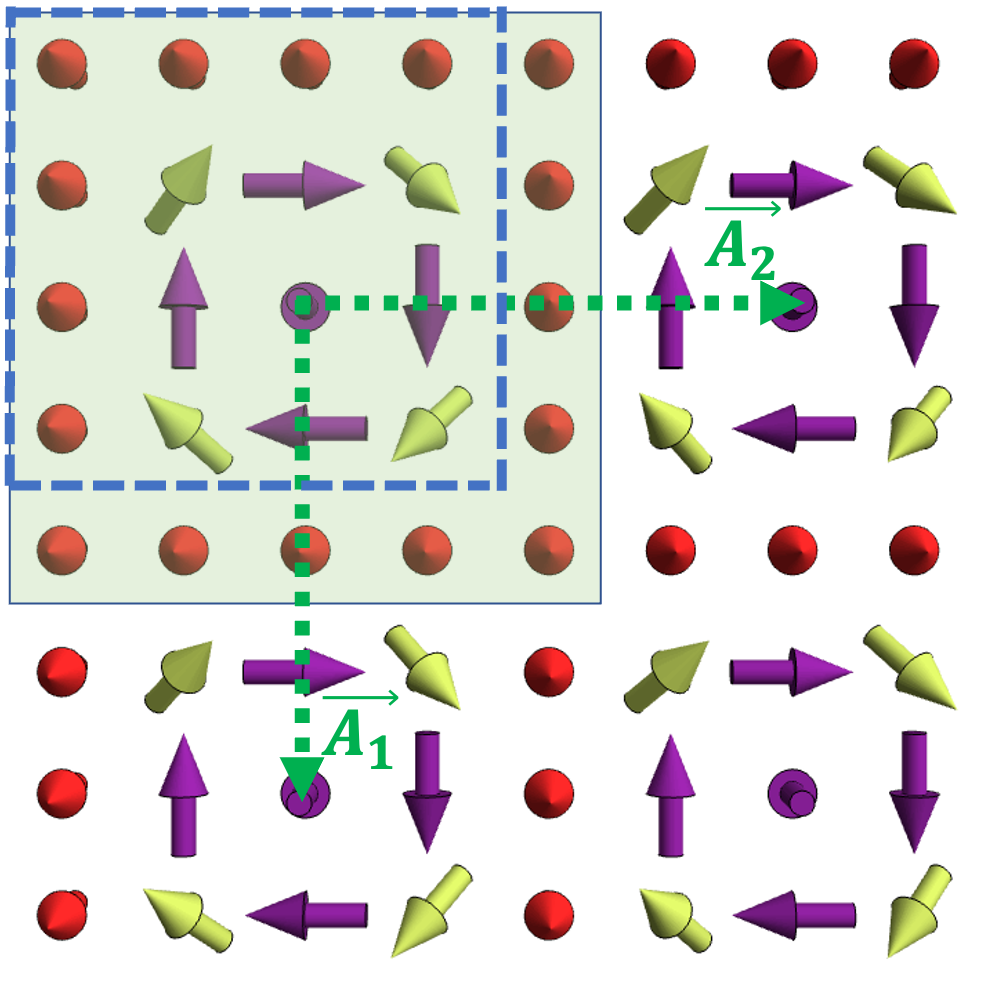

Figure 1: This the lattice modeled here. The unit cell is the highlighted block in dotted blue box. And the tranlation vectors are shown by the green dotted arrows.

In [5]:
import numpy as np
import matplotlib
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#  Parameters
lamda = 2           #radius of the skyrmion 
m = 1
gamma = 0
t = 1

# Skyrmion texture design #
# r-matrix calculations:
r = np.zeros( (2*lamda+1, 2*lamda+1) )
for row in range(0, 2*lamda+1,1):
    for column in range(0, 2*lamda+1, 1):
        r[row][column] = np.sqrt((row-lamda)**2 + (-column+lamda)**2)
# print(r)

# theta-matrix calculations(radians):
theta = np.zeros( (2*lamda+1, 2*lamda+1) )
for row in range(0, 2*lamda+1,1): 
    for column in range(0, 2*lamda+1, 1):
        if r[row][column] <= lamda :
            theta[row][column] = (np.pi*(1 - (r[row][column])/lamda))
        else:
            theta[row][column] = 0
# print(theta)

# alpha - matrix calculation(radians):
alpha = np.zeros( (2*lamda+1, 2*lamda+1) )
for row in range(0, 2*lamda+1,1): 
    for column in range(0, 2*lamda+1, 1):    
        j = -row + lamda 
        i = column - lamda
        if i==0 and j==0:
            alpha[row][column] = 0
        elif i == 0 and j>0:
            alpha[row][column] = np.pi/2
        elif i == 0 and j<0:
            alpha[row][column] = 3*np.pi/2
        elif j == 0 and i >0:
            alpha[row][column] = 0
        elif j == 0 and i < 0:
            alpha[row][column] = np.pi
        elif i>0 and j>0:
            alpha[row][column] = np.arctan(j/i)   #first quadrant
        elif i<0 and j<0:
            alpha[row][column] = np.pi + np.arctan(j/i)  #third quadrant
        elif i>0 and j<0:
            alpha[row][column] = 2*np.pi - np.arctan(abs(j/i)) #fourth quadrant 
        elif i<0 and j>0: 
            alpha[row][column] = (np.pi/2) + np.arctan(abs(j/i)) #second quadrant
# print(alpha)  

# phi definition 
phi = np.zeros( (2*lamda+1, 2*lamda+1) )
phi = m * alpha + gamma
#print(phi) 

# forming spin texture in bloch form;
chi_ket = np.zeros((2*lamda+1, 2*lamda+1, 2), dtype=complex)
for row in range(0, 2*lamda+1,1): 
    for column in range(0, 2*lamda+1, 1):
        chi_ket[row][column][0] = np.cos(theta[row][column]/2)
        chi_ket[row][column][1] = np.sin(theta[row][column]/2) * np.exp(1j * phi[row][column])
# print(chi_ket)

# forming chi_bra:
chi_bra = np.zeros((2*lamda+1, 2*lamda+1, 2), dtype=complex)
for row in range(0, 2*lamda+1,1): 
    for column in range(0, 2*lamda+1, 1):
        chi_bra[row][column][0] = chi_ket[row][column][0].conjugate()
        chi_bra[row][column][1] = chi_ket[row][column][1].conjugate()
# print(chi_bra[0][0])


#defining chi_vector for convience
chi_ket_array = []
chi_bra_array = []
for row in range(0, 2*lamda):
    for column in range(0, 2*lamda):
        m = (row * 2 * lamda) + column 
        chi_ket_array.append(chi_ket[row][column])
        chi_bra_array.append(chi_bra[row][column])

# print(chi_bra_array)
# print(chi_ket_array

# Indexing the magnetic unit cell and forming neighbour table
index = np.zeros((2*lamda, 2*lamda))
for row in range(0, 2*lamda):
    for column in range(0, 2*lamda):
        m = (row * 2 * lamda) + column 
        index[row][column] = m

Uindex = np.zeros((2*lamda)**2)
Dindex = np.zeros((2*lamda)**2)
Lindex = np.zeros((2*lamda)**2)
Rindex = np.zeros((2*lamda)**2)
for row in range(0, 2*lamda):
    for column in range(0, 2*lamda):
        m = (row * 2 * lamda) + column 
        if row - 1 == -1 :
            up = 2*lamda - 1
        else :
            up = row - 1
    
        if row + 1 > (2*lamda) - 1 :
            down = 0
        else :
            down = row + 1
        
        if column - 1 == -1 :
            left = 2*lamda - 1
        else :
            left = column - 1
    
        if column + 1 > (2*lamda) - 1 :
            right = 0
        else :
            right = column + 1
        Uindex[m] = index[up][column]
        Dindex[m] = index[down][column]    
        Lindex[m] = index[row][left]
        Rindex[m] = index[row][right]         
        
#print(index)
#print(Uindex)
#print(Dindex)
#print(Lindex)
#print(Rindex)

In [6]:
# Hamiltonian definition
def H(kx, ky):
    Hij = np.zeros(((2*lamda)**2, (2*lamda)**2), dtype=np.complex128)
    for i in range(0, (2*lamda)**2):
        left, right, up, down  = int(Lindex[i]), int(Rindex[i]), int(Uindex[i]), int(Dindex[i])  # Convert to integers
        Hij[i][i] = 0
        Hij[up][i] = t * np.exp(1j * ky) * np.dot(chi_bra_array[up], chi_ket_array[i])
        Hij[down][i] = t * np.exp(-1j * ky) * np.dot(chi_bra_array[down], chi_ket_array[i])
        Hij[left][i] = t * np.exp(-1j * kx) * np.dot(chi_bra_array[left], chi_ket_array[i])
        Hij[right][i] = t * np.exp(1j * kx) * np.dot(chi_bra_array[right], chi_ket_array[i])
    return Hij 

# define the derivative of the hamiltonian (kx):
def H_dx(kx, ky):
    Hij = np.zeros(((2*lamda)**2, (2*lamda)**2), dtype=np.complex128)
    for i in range(0, (2*lamda)**2):
        left, right, up, down  = int(Lindex[i]), int(Rindex[i]), int(Uindex[i]), int(Dindex[i])  # Convert to integers
        Hij[i][i] = 0
        Hij[up][i] = 0
        Hij[down][i] = 0
        Hij[left][i] = -1j * t * np.exp(-1j * kx) * np.dot(chi_bra_array[left], chi_ket_array[i])
        Hij[right][i] = 1j * t * np.exp(1j * kx) * np.dot(chi_bra_array[right], chi_ket_array[i])
    return Hij 
                
def H_dy(kx, ky):
    Hij = np.zeros(((2*lamda)**2, (2*lamda)**2), dtype=np.complex128)
    for i in range(0, (2*lamda)**2):
        left, right, up, down  = int(Lindex[i]), int(Rindex[i]), int(Uindex[i]), int(Dindex[i])  # Convert to integers
        Hij[i][i] = 0
        Hij[up][i] = 1j * t * np.exp(1j * ky) * np.dot(chi_bra_array[up], chi_ket_array[i])
        Hij[down][i] = -1j * t * np.exp(-1j * ky) * np.dot(chi_bra_array[down], chi_ket_array[i])
        Hij[left][i] = 0
        Hij[right][i] = 0
    return Hij 

100%|██████████| 1421/1421 [00:05<00:00, 280.42it/s]


([<matplotlib.axis.YTick at 0x7fb431b97c10>,
 [Text(0, -4.0, '$-4.0$'),
  Text(0, -3.0, '$-3.0$'),
  Text(0, -2.0, '$-2.0$'),
  Text(0, -1.0, '$-1.0$'),
  Text(0, 0.0, '$0$'),
  Text(0, 1.0, '$1.0$'),
  Text(0, 2.0, '$2.0$'),
  Text(0, 3.0, '$3.0$'),
  Text(0, 4.0, '$4.0$')])

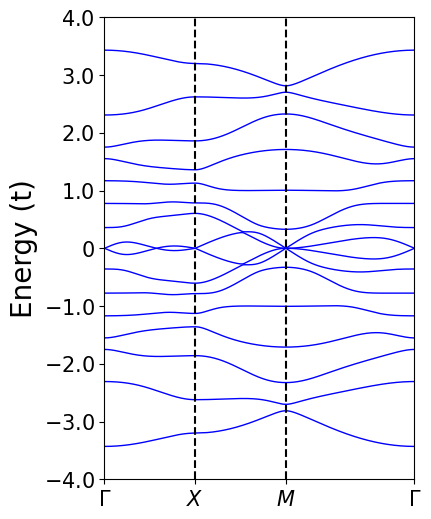

In [10]:
# Path in the reciprocal space
GX = []
XM = []
MG = []
for i in tqdm(range(0,1001)):
    GX.append([0 + ( (3.14159 * i) / (2 * lamda * 1000) ), 0])
    XM.append([3.14159/(2*lamda), 0 + ( (3.14159 * i) / (2 * lamda * 1000) )])
for i in tqdm(range(0,1421)):
    point = (3.14159/(2*lamda)) * ((1420 - i) / (1420)) 
    MG.append([point, point])
    point = 0
    
band = np.zeros(((2 * lamda)**2, len(GX) + len(XM) + len(MG)))
slno = [i+1 for i in range(len(GX) + len(XM) + len(MG))]

for i in tqdm(range(0, len(GX))):
    for b_index in range(0, (2 * lamda)**2):
        band[b_index][i] = np.linalg.eigvalsh(H(GX[i][0], GX[i][1]))[b_index]

for i in tqdm(range(0, len(XM))):
    for b_index in range(0, (2 * lamda)**2):
        band[b_index][len(GX) + i] = np.linalg.eigvalsh(H(XM[i][0], XM[i][1]))[b_index]
        
for i in tqdm(range(0, len(MG))):
    for b_index in range(0, (2 * lamda)**2):
        band[b_index][len(GX) + len(XM) + i] = np.linalg.eigvalsh(H(MG[i][0], MG[i][1]))[b_index]
        
# full band plot 
f = plt.figure(figsize=(4,6));   
for i in range((2 * lamda)**2):
    plt.plot(slno, band[i], c = 'blue', linestyle ='-', linewidth = 1)

plt.axvline(len(GX), c='k', linestyle='--')
plt.axvline(len(GX) + len(XM) ,c='k', linestyle='--')
plt.ylabel("Energy (t)", fontsize=20);         plt.axis('tight');
plt.xlim(0, len(GX) + len(XM) + len(MG))
# Customize x-axis ticks with Greek symbols
plt.xticks([0, len(GX), len(GX) + len(XM), len(GX) + len(XM) + len(MG)],
           [r'$\Gamma$', r'$X$', r'$M$', r'$\Gamma$'],fontsize=15)
plt.yticks([-4.0, -3,  -2,  -1,  0,  1.0, 2.0,  3.0, 4.0], [r'$-4.0$', r'$-3.0$',  r'$-2.0$', r'$-1.0$',  r'$0$',  r'$1.0$',  r'$2.0$',  r'$3.0$', r'$4.0$'], size=15)    

In [16]:
# Berry curvature calculation
grid_size = 200
kx_array = [(2 * 3.14159 * inc)/(2 * lamda * grid_size) for inc in range(0, grid_size + 1)]
ky_array = [(2 * 3.14159 * inc)/(2 * lamda * grid_size) for inc in range(0, grid_size + 1)]
# print(kx_array)

eta = 10**-5

def E_value(kx, ky):
    eigenvalues = np.linalg.eigvalsh(H(kx, ky))
    return eigenvalues

def sorted_kets(kx, ky):
    eigenvalues, eigenvectors = np.linalg.eigh(H(kx,ky))
    a = np.transpose(eigenvectors)
    return a

def b_curvature(kx, ky, band_index):
    berry_curvature = 0
    
    band_ev = E_value(kx, ky)[band_index]
    filtered_ev = [ev for ev in E_value(kx, ky) if ev != band_ev]
    band_ket = sorted_kets(kx, ky)[band_index]
    filtered_ket = [vec for index, vec in enumerate(sorted_kets(kx, ky)) if index != band_index]
    
    dh_x = H_dx(kx, ky)
    dh_y = H_dy(kx, ky)
    
    for i in range(0, len(filtered_ket)):
        berry_curvature += (np.dot(np.conj(band_ket), np.dot(dh_x, filtered_ket[i])) * np.dot(np.conj(filtered_ket[i]), np.dot(dh_y, band_ket)) - np.dot(np.conj(band_ket), np.dot(dh_y, filtered_ket[i])) * np.dot(np.conj(filtered_ket[i]), np.dot(dh_x, band_ket))) / ((band_ev - filtered_ev[i])**2 + eta**2)
    
    return -berry_curvature.imag

b_c_band = np.zeros((grid_size+1, grid_size+1))     

for i in tqdm(range(0, len(kx_array))):
    for j in range(0, len(ky_array)):
        kx = kx_array[i]
        ky = ky_array[j]
        b_c_band[i][j] = b_curvature(kx, ky, 0)/ (4 * lamda * lamda)
        
        

100%|██████████| 201/201 [00:54<00:00,  3.70it/s]


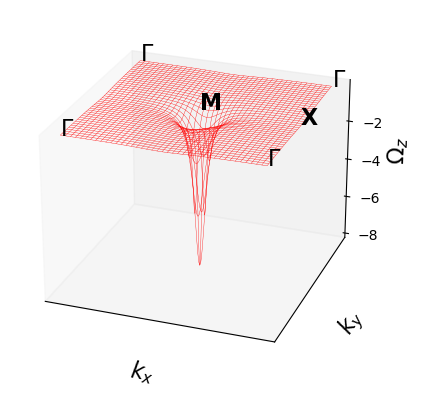

In [17]:
# Create a figure and a 3D axis
x, y = np.meshgrid(kx_array, ky_array)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the data
ax.plot_wireframe(x, y,  b_c_band, color='red', linewidth=0.25,rstride=5, cstride=5)

# Set labels and title
ax.set_xlabel('$k_x$',fontsize = 16)
ax.set_ylabel('$k_y$',fontsize = 16)
ax.set_zlabel('$ \Omega_z $', fontsize = 16)

# Remove x and y ticks
ax.set_xticks([])
ax.set_yticks([])

# Add the letter 'M' at (0, 1.50, 0)
ax.text(0, 3.14/lamda, 0, '$\Gamma$', color='black', fontsize=16, fontweight='bold')
ax.text(0, 0, 0, '$\Gamma$', color='black', fontsize=16, fontweight='bold')
ax.text( 3.14/lamda, 3.14/lamda, 0, '$\Gamma$', color='black', fontsize=16, fontweight='bold')
ax.text( 3.14/lamda, 0, 0, '$\Gamma$', color='black', fontsize=16, fontweight='bold')
ax.text( 3.14/(2*lamda), 3.14/(2*lamda), 0, 'M', color='black', fontsize=16, fontweight='bold')
ax.text( 0, 3.14/(2*lamda), 0, 'X', color='black', fontsize=16, fontweight='bold')


# Remove grid lines
ax.grid(False)
 
ax.view_init(elev=  25, azim=110)
# Show the plot
plt.show()

In [18]:
# Band data
bands = []
for band_index in tqdm(range(int((2 * lamda)**2))):
    for kx in kx_array:
        for ky in ky_array:
            bands.append(E_value(kx, ky)[band_index])
            
berry_curvature = []
for band_index in tqdm(range(int((2 * lamda)**2))):
    for kx in kx_array:
        for ky in ky_array:
            berry_curvature.append(b_curvature(kx, ky, band_index))


100%|██████████| 16/16 [14:03<00:00, 52.74s/it]


In [19]:
Ef = [-5 + i/100 for i in range(1001)]
kT = 0.00000001

# Kubo formula implimentation
sigma = []
for fermi_energy in tqdm(Ef):
    energies = []
    bc_list = []
    for i in range(len(bands)):
        if bands[i] <= fermi_energy:
            energies.append(bands[i])
            bc_list.append(berry_curvature[i])
    if energies != []:
        conductivity = 0
        for i in range(len(energies)):
            conductivity += bc_list[i]/(1 + np.exp((energies[i] - fermi_energy)/kT))
        sigma.append(conductivity * (1/(2*3.14)) * (3.14/(lamda*grid_size))**2)
    else:
        sigma.append(0)  # Append a default value if no tuples were selected


100%|██████████| 1001/1001 [10:57<00:00,  1.52it/s]


(-4.0, 4.0)

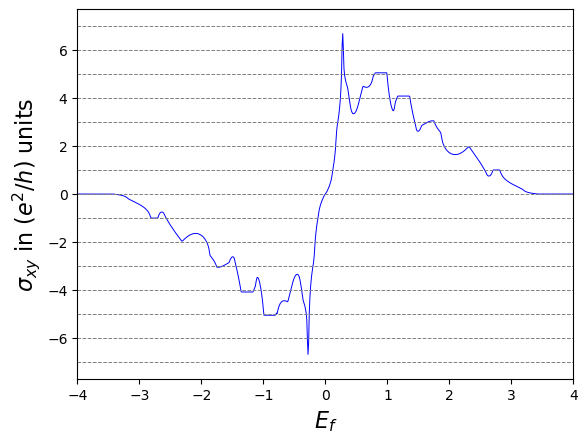

In [20]:
f = plt.figure();   
plt.plot( Ef, sigma, c = 'blue', linestyle='-', linewidth = 0.7)
# Add grid lines at specific y-values
for y_value in range(-7, 8):
    plt.axhline(y=y_value, color='gray', linestyle='--', linewidth=0.7)
plt.xlabel("$E_f$", fontsize=16); plt.axis('tight')
plt.ylabel("$\sigma_{xy}$ in ($e^2/h$) units", fontsize=16); plt.axis('tight')
plt.xlim(-4,4)